# Homework 5 -  The eternal significance of publications and citations!

<p align="center">
<img src="https://filelist.tudelft.nl/Library/Themaportalen/Research%20Analytics/C12.png" width = 800>
</p>

Citation networks, intricately woven through references in scholarly papers, play a pivotal role in mapping the evolution of knowledge in academic research. Analyzing these networks is essential for identifying influential works, tracking idea development, and gauging the impact of research. Leveraging graph analysis enhances our ability to uncover hidden patterns, predict emerging trends, and comprehend the intricate relationships within these networks. 

This time, you and your team have decided to dive deep into the citation realm. Now, you will deal with graphs to determine relevant characteristics and highlights from the relations among those publications.

Let's hands-on this!

In this Homework, you will explore the paper citation universe, exploring relations among multiple academic publications!

* __Backend:__ where you need to develop efficient algorithms that define the *functionalities of the system*
* __Frontend:__ where you provide *visualization for queries entered by the user*

__IMPORTANT:__ To deal with functionalities 1 and 2 and visualization of graphs, you can freely use libraries such as `networkx` or any other tool you choose. Still, when writing an algorithm for functionalities 3, 4, and 5, it must be implemented yourself using proper data structures, __without any library that computes some algorithm steps for you__.

------------------

## 1. Data 
In this homework, you will work on a dataset that contains information about a group of papers and their citation relationships. You can find and download the dataset [here](https://www.kaggle.com/datasets/mathurinache/citation-network-dataset)

### Graphs setup 
Based on the available data, you will create two graphs to model our relationships as follows: 

1. __Citation graph__: This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

2. __Collaboration graph__: This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.

### Data pre-processing 

The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components. 

As a result, you will attempt to approximate that most connected component by performing the following steps: 
1. Identify the __top 10,000__ papers with the <ins>highest number of citations</ins>.
2. Then the __nodes__ of your graphs would be as follows:

   __Citation graph__: you can consider each of the papers as your nodes

   __Collaboration graph__: the authors of these papers would be your nodes
    
4. For the __edges__ of the two graphs, you would have the following cases:
   
   __Citation graph__: only consider the citation relationship between these 10,000 papers and ignore the rest.
   
   __Collaboration graph__: only consider the collaborations between the authors of these 10,000 papers and ignore the rest. 

---------------

Here's several helpful packages to load and set-up

In [1]:
import numpy as np
import pandas as pd
import ijson
import time
import csv
import numpy as np
from decimal import Decimal
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from itables import init_notebook_mode
from libs.backend import * # Custom backend functionalities
from libs.frontend import * # Custom frontend to display backend functionalities
import ipywidgets as widgets
import warnings

In [2]:
# Make sure that plots are in-line
%matplotlib inline
# Make the tables interactive
init_notebook_mode(all_interactive=True)
# Set plot grid parameter
mpl.rcParams['grid.linestyle'] = "-" 
# Suppress DeprecationWarnings from IpyWidgets
warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>

Converting Json to CSV (https://www.kaggle.com/code/shreyasbhatk/csv-conversion-all-fields)

In [2]:
start = time.process_time()

PAPER = []
Author = []
count = 0

with open('dblp.v12.json', "rb") as f, open("output.csv", "w", newline="") as csvfile:
    fieldnames = ['id', 'title', 'year', 'author_name', 'author_org', 'author_id', 'n_citation', 'doc_type',
                  'reference_count', 'references', 'venue_id', 'venue_name', 'venue_type', 'doi', 'keyword','volume','issue','publisher',
                  'weight', 'indexed_keyword', 'inverted_index']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for i, element in enumerate(ijson.items(f, "item")):
        paper = {}
        paper['id'] = element['id']
        paper['title'] = element['title']

        year = element.get('year')
        if year:
            paper['year'] = year
        else:
            paper['year'] = np.nan

        author = element.get('authors')
        if author:
            Author = element['authors']
            author_name = []
            author_org = []
            author_id = []

            for i in Author:
                if 'name' in i and 'id' in i and 'org' in i:
                    author_name.append(str(i['name']))  # Convert to string
                    author_id.append(str(i['id']))
                    author_org.append(str(i['org']))
                else:
                    author_name.append(str(np.nan))  # Convert to string
                    author_id.append(str(np.nan))
                    author_org.append(str(np.nan))

            paper['author_name'] = ';'.join(author_name)
            paper['author_org'] = ';'.join(author_org)
            paper['author_id'] = ';'.join(author_id)

        n_citation = element.get('n_citation')
        if n_citation:
            paper['n_citation'] = n_citation
        else:
            paper['n_citation'] = np.nan

        doc_type = element.get('doc_type')
        if doc_type:
            paper['doc_type'] = doc_type
        else:
            paper['doc_type'] = np.nan

        references = element.get('references')
        if references:
            paper['reference_count'] = len(references)
            paper['references'] = ';'.join(str(int(r)) for r in references)
        else:
            paper['references'] = np.nan

        venue = element.get('venue')
        if venue:
            if 'id' in venue and 'raw' in venue and 'type' in venue:
                paper['venue_id'] = str(venue['id'])
                paper['venue_name'] = venue['raw']
                paper['venue_type'] = venue['type']
            else:
                paper['venue_id'] = np.nan
                paper['venue_name'] = np.nan
                paper['venue_type'] = np.nan
        else:
            paper['venue_id'] = np.nan
            paper['venue_name'] = np.nan
            paper['venue_type'] = np.nan

        doi = element.get('doi')
        if doi:
            paper['doi'] = f"https://doi.org/{doi}"
        else:
            paper['doi'] = np.nan

        fos = element.get('fos')
        if fos:
            fosunparsed = element['fos']
            keyword = []
            weight = []

            for i in fosunparsed:
                if isinstance(i['w'], (int, float, Decimal)):
                    keyword.append(str(i['name']))  # Convert to string
                    weight.append(str(i['w']))
                else:
                    keyword.append(str(np.nan))  # Convert to string
                    weight.append(str(np.nan))

        else:
            keyword = []
            weight = []

        paper['keyword'] = ';'.join(keyword)
        paper['weight'] = ';'.join(weight)

        indexed_abstract = element.get('indexed_abstract')
        if indexed_abstract:
            indexed_abstracts = indexed_abstract.get('InvertedIndex')
            inverted_vector = []
            keywords = []

            for i in indexed_abstracts:
                if i:
                    keywords.append(str(i))  # Convert to string
                    inverted_vector.append(str(indexed_abstracts[i]))  # Convert to string
        else:
            keywords = []
            inverted_vector = []

        paper['indexed_keyword'] = ';'.join(keywords)
        paper['inverted_index'] = ';'.join(inverted_vector)
        
        publisher= element.get('publisher')
        if publisher:
            paper['publisher']=publisher
        else:
            paper['publisher']=np.nan
        volume = element.get('volume')
        if volume:
            paper['volume']=volume
        else:
            paper['volume']=np.nan
        issue = element.get('issue')
        if issue:
            paper['issue']=issue
        else:
            paper['issue']=np.nan
        count += 1
        writer.writerow(paper)

        if count % 4800 == 0:
            print(f"{count}:{round((time.process_time() - start), 2)}s ", end="")

4800:0.28s 9600:0.59s 14400:0.95s 19200:1.3s 24000:1.62s 28800:2.06s 33600:2.45s 38400:2.72s 43200:3.11s 48000:3.45s 52800:3.78s 57600:4.19s 62400:4.52s 67200:4.94s 72000:5.36s 76800:5.75s 81600:6.14s 86400:6.5s 91200:6.86s 96000:7.2s 100800:7.67s 105600:8.12s 110400:8.56s 115200:8.95s 120000:9.3s 124800:9.58s 129600:10.05s 134400:10.28s 139200:10.36s 144000:10.72s 148800:10.92s 153600:11.27s 158400:11.69s 163200:12.02s 168000:12.27s 172800:12.56s 177600:12.91s 182400:13.38s 187200:13.72s 192000:14.11s 196800:14.41s 201600:14.69s 206400:14.94s 211200:15.22s 216000:15.52s 220800:15.86s 225600:16.19s 230400:16.52s 235200:16.86s 240000:17.22s 244800:17.62s 249600:17.98s 254400:18.42s 259200:18.92s 264000:19.45s 268800:19.95s 273600:20.48s 278400:20.88s 283200:21.39s 288000:22.05s 292800:22.41s 297600:22.89s 302400:23.38s 307200:23.66s 312000:24.33s 316800:24.86s 321600:25.33s 326400:25.62s 331200:26.11s 336000:26.42s 340800:26.75s 345600:27.11s 350400:27.52s 355200:28.09s 360000:28.56s 36

-------------------

### Data Pre-processing Algorithm

#### Step 1: Load Data and Identify Top 10,000 Papers
1. Load the dataset into a Pandas DataFrame.
2. Sort the DataFrame by the `n_citation` column in descending order to get the papers with the highest number of citations.
3. Slice the top 10,000 records to work with.

#### Step 2: Construct Nodes for Both Graphs
- For the **Citation Graph**:
  - Extract the `id` field of the top 10,000 papers to use as nodes.
- For the **Collaboration Graph**:
  - Extract the `author_id` fields of the top 10,000 papers, parse the individual author IDs, and use them as nodes.

#### Step 3: Construct Edges for Both Graphs
- For the **Citation Graph**:
  - For each of the top 10,000 papers, parse its `references` field to find other papers it cites.
  - Filter those references to only include papers within the top 10,000.
  - Add directed edges from the citing paper to the cited papers.
- For the **Collaboration Graph**:
  - For each paper, parse the `author_id` field to find all pairs of authors that have collaborated.
  - Add undirected edges between these authors.
  - The weighting scheme could be the number of papers co-authored by the pair, meaning each additional paper they co-author together increases the weight of the edge by one.

### Approximating the Most Connected Component

To identify the most connected component, we would analyze the constructed graphs:
1. Use NetworkX to find connected components in the collaboration graph (since it's undirected) and weakly connected components in the citation graph (since it's directed).
2. Determine the size of each component.
3. Identify the largest component.

### Code Implementation:

In [3]:
# Load data into a Pandas DataFrame
df = pd.read_csv('output.csv')

# Sort by number of citations and get the top 10,000 papers
top_papers = df.sort_values('n_citation', ascending=False).head(10000)

# Citation Graph Nodes
citation_nodes = top_papers['id'].tolist()

# Collaboration Graph Nodes
collaboration_nodes = set()

# Before applying the lambda, ensure NaN values are handled, e.g., by converting to a string
top_papers['author_id'] = top_papers['author_id'].fillna('')

# Now applying the lambda function
top_papers['author_id'].str.split(';').apply(lambda x: collaboration_nodes.update(x) if isinstance(x, list) else None)
# Empty and NaN ids are dropped
collaboration_nodes.remove('')
collaboration_nodes.remove('nan')

# Create graphs
citation_graph = nx.DiGraph()
collaboration_graph = nx.Graph()

# Add nodes to graphs
citation_graph.add_nodes_from(citation_nodes)
collaboration_graph.add_nodes_from(collaboration_nodes)

# Create a dictionary with authors ids as keys and authors names as values
authors_names = dict()
top_papers.apply(lambda row: authors_names.update(dict(zip(row['author_id'].split(';'),row['author_name'].split(';')))) if not(pd.isna(row['author_name'])) else None, axis = 1)
# NaN name is dropped
del authors_names['nan']

# Add papers titles and authors names to node attributes
nx.set_node_attributes(citation_graph, dict(zip(top_papers.id, top_papers.title)), name = 'title')
nx.set_node_attributes(collaboration_graph, authors_names, name = 'author_name')

# Add edges to Citation Graph
for _, row in top_papers.iterrows():
    if pd.notna(row['references']):
        cited_papers = [int(x) for x in row['references'].split(';') if x.isdigit()]
        for cited in cited_papers:
            if cited in citation_nodes:
                citation_graph.add_edge(row['id'], cited)

# Add edges to Collaboration Graph with a simple weighting scheme
edges_labels = dict()
for _, row in top_papers.iterrows():
    authors = str(row['author_id']).split(';') if pd.notnull(row['author_id']) else []
    authors = [obj for obj in authors if obj != 'nan']
    for i, author_i in enumerate(authors):
        for author_j in authors[i+1:]:
            if author_i and author_j:  # Ensure author_i and author_j are not empty strings
                if collaboration_graph.has_edge(author_i, author_j):
                    collaboration_graph[author_i][author_j]['weight'] += 1
                else:
                    collaboration_graph.add_edge(author_i, author_j, weight=1)
                    edges_labels.update({(author_i,author_j):row['title']})

# Associate to each edge of the collaboration graph the name of the correspondent paper
nx.set_edge_attributes(collaboration_graph, edges_labels, name = 'paper')

# Identify the largest connected component in the collaboration graph
largest_collaboration_cc = max(nx.connected_components(collaboration_graph), key=len)
subgraph_collaboration_graph = collaboration_graph.subgraph(largest_collaboration_cc)

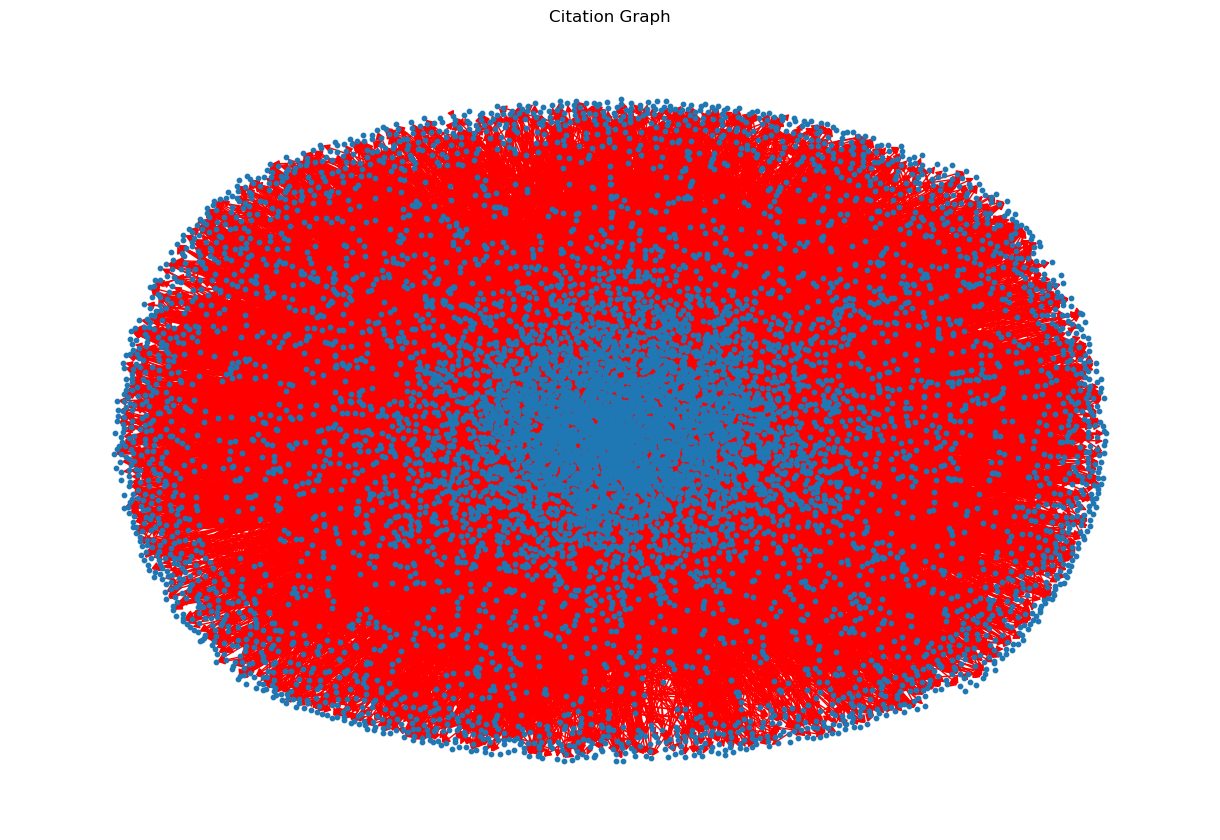

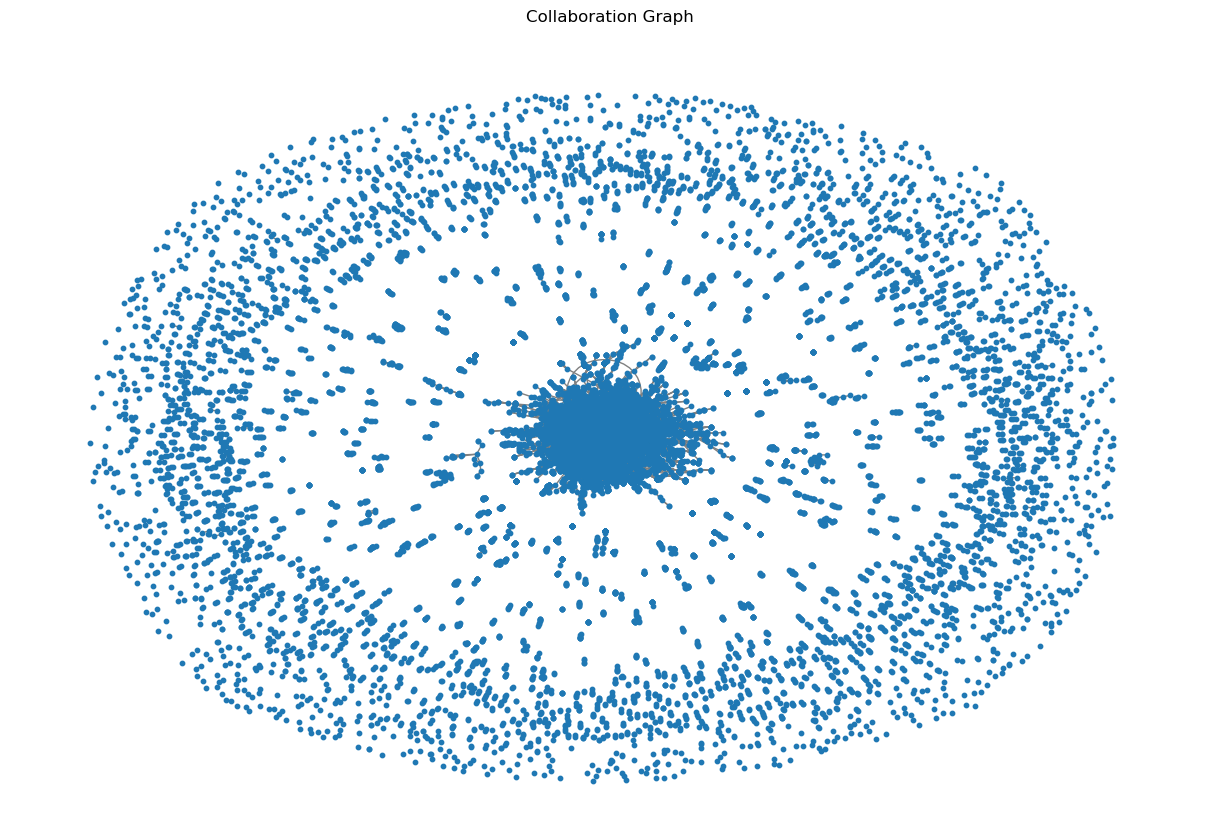

In [3]:
# Visualizing the citation graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(citation_graph)
nx.draw(citation_graph, pos, node_size=10, arrows=True, edge_color='red', with_labels=False)
plt.title("Citation Graph")
plt.show()

# Visualizing the collaboration graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(collaboration_graph)
nx.draw(collaboration_graph, pos, node_size=10, edge_color='gray', with_labels=False)
plt.title("Collaboration Graph")
plt.show()

Visualizing the Largest Connected Component in the Collaboration Graph

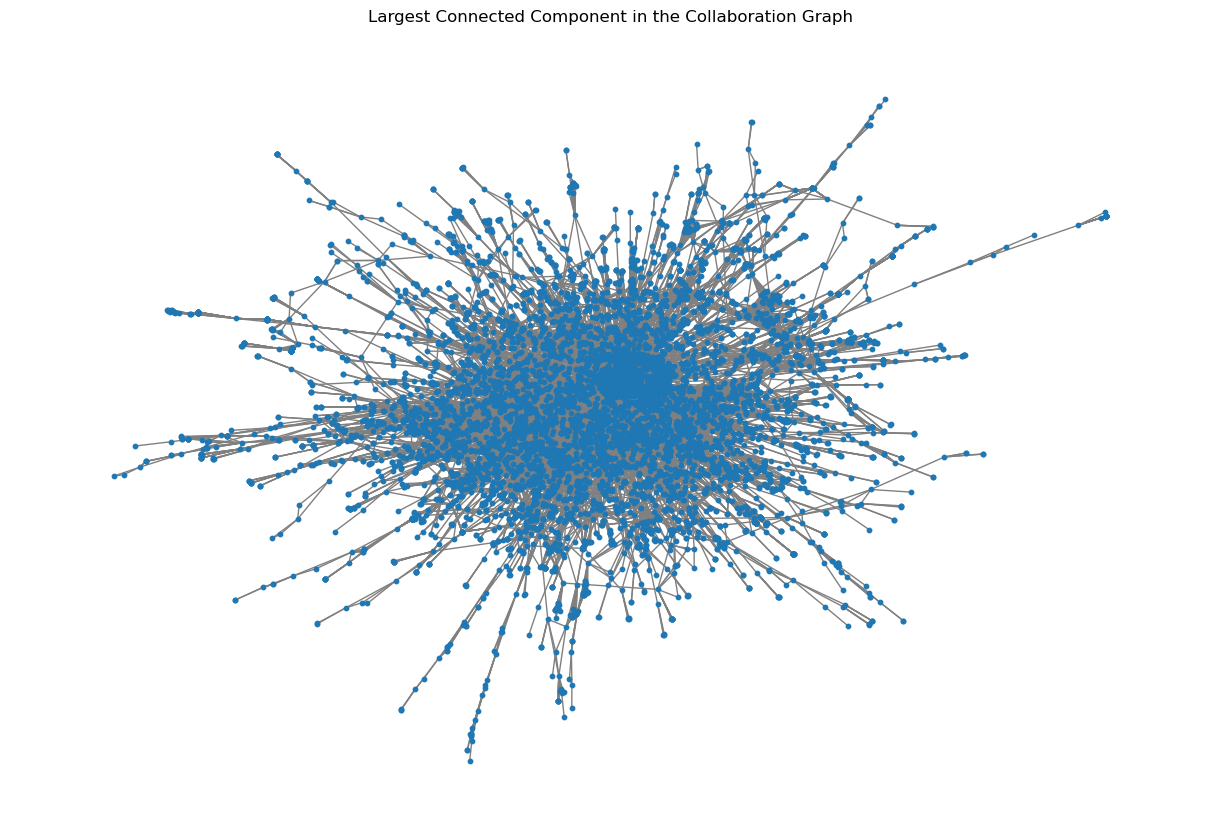

In [4]:
# Visualizing the Largest Connected Component in the Collaboration Graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph_collaboration_graph)
nx.draw(subgraph_collaboration_graph, pos, node_size=10, edge_color='gray', with_labels=False)
plt.title("Largest Connected Component in the Collaboration Graph")
plt.show()

-------------

To save or export the graphs as GraphML

In [11]:
# Assuming citation_graph and collaboration_graph are already created NetworkX graph objects
nx.write_graphml(citation_graph, "citation_graph.graphml")
nx.write_graphml(collaboration_graph, "collaboration_graph.graphml")
nx.write_graphml(subgraph_collaboration_graph, "subgraph_collaboration_graph.graphml")

To read or import the saved graphs from GraphML

In [3]:
citation_path = 'citation_graph.graphml'
collaboration_path = 'collaboration_graph.graphml'
subcollaboration_path = 'subgraph_collaboration_graph.graphml'

# Load the citation graph from GraphML file
citation_graph = nx.read_graphml(citation_path)

# Load the collaboration graph from GraphML file
collaboration_graph = nx.read_graphml(collaboration_path)

# Load the subgraph collaboration graph from GraphML file
subgraph_collaboration_graph = nx.read_graphml(subcollaboration_path)

----------

## 2. Controlling system

In this section, five different functionalities to **analyze** the produced graphs are implemented *from scratch* and their outputs are visualized. You can check the full code inside the files *backend.py* (implementation) and *frontend.py* (visualization).  
Please note that the visualizations are interactive, making the user able to dinamically select the functionalities' arguments. Unfortunately, the widgets are trurly interactive if and only if the notebook is run in local. 

### Functionality 1 - Graph's features

This first functionality permits to examine a graph and report some of its features. Leveraging the library *networkX*, it takes in input the graph and (eventually) an integer *k*, returning the following items:

   - A table containing the following general information about the graph:
        - **Number of nodes** in the graph
        - **Number of the edges** in the graph
        - **Density** of the graph
        - **Average degree** of the graph
        - Whether the network is **sparse or dense**
   - A table that lists the graph's **hubs**
   - A plot depicting the distribution of the **citations received** by papers (Citation graph)
   - A plot depicting the distribution of the **given citations** by papers (Citation graph)
   - A plot depicting the **number of collaborations of the top *k* authors** by degree (Collaboration graph)
   
To have a better understanding of the data, it was **executed on both the Citation and Collaboration Graphs**. 

In [4]:
# CITATION GRAPH
first_funct = widgets.interactive(visual_1, 
                          {'manual': True},
                          G = widgets.Dropdown(options=[('Citation Graph',citation_graph),('Collaboration Graph',collaboration_graph),('Collaboration Graph (Largest Component)',subgraph_collaboration_graph)], description='Graph:'),
                          k = widgets.IntSlider(min = 2, max = 50, step = 1, value = 20, description = 'Top Authors:'))
first_funct.children[-1].layout.height = '1450px'
first_funct

interactive(children=(Dropdown(description='Graph:', options=(('Citation Graph', <networkx.classes.digraph.DiG…

In [5]:
# COLLABORATION GRAPH
first_funct = widgets.interactive(visual_1, 
                          {'manual': True},
                          G = widgets.Dropdown(options=[('Citation Graph',citation_graph),('Collaboration Graph',collaboration_graph),('Collaboration Graph (Largest Component)',subgraph_collaboration_graph)], description='Graph:'),
                          k = widgets.IntSlider(min = 2, max = 50, step = 1, value = 20, description = 'Top Authors:'))
first_funct.children[-1].layout.height = '1450px'
first_funct

interactive(children=(Dropdown(description='Graph:', options=(('Citation Graph', <networkx.classes.digraph.DiG…

### Functionality 2 - Nodes' contribution

This functionality uses the methods embedded in the *networkX* library to compute the following **centrality measures** for a chosen node: 

   - **Betweeness Centrality**
   - **PageRank** 
   - **Closeness Centrality**
   - **Degree Centrality**

The results are displayed in a table. Please note that, since it is needed to specify the node id to calculate the centrality measures, a **node id finder** was added: it makes the user able to find a node id by typing either the author's name or the paper's title.

In [6]:
finder = widgets.interactive(visual_id_finder, 
                          {'manual': True},
                          G = widgets.Dropdown(options=[('Citation Graph',citation_graph),('Collaboration Graph',collaboration_graph),('Collaboration Graph (Largest Component)',subgraph_collaboration_graph)], description='Graph:'),
                          input_str = widgets.Text(value='',placeholder='Type name or title',description='Name/Title:'))
finder.children[-1].layout.height = '200px'
finder

interactive(children=(Dropdown(description='Graph:', options=(('Citation Graph', <networkx.classes.digraph.DiG…

In [7]:
second_funct = widgets.interactive(visual_2, 
                          {'manual': True},
                          G = widgets.Dropdown(options=[('Citation Graph',citation_graph),('Collaboration Graph',collaboration_graph),('Collaboration Graph (Largest Component)',subgraph_collaboration_graph)], description='Graph:'),
                          v = widgets.Text(value='',placeholder='Type node ID',description='Node ID:'))
second_funct.children[-1].layout.height = '200px'
second_funct

interactive(children=(Dropdown(description='Graph:', options=(('Citation Graph', <networkx.classes.digraph.DiG…

### Functionality 3 - Shortest ordered walk

DESC WIP We anticipate seeing the Functionality 3 report in Visualization 3. To be more specific, we expect you to have the following report format:

    Print the papers needed to be crossed in the shortest walk in order
    Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)


In [8]:
N_slider = widgets.IntSlider(min = 2, max = 5000, step = 1, value = 500, description = 'Top Authors by degree to consider:', layout = widgets.Layout(width='75%'))
drop = widgets.Dropdown(options=[('Collaboration Graph',collaboration_graph),('Collaboration Graph (Largest Component)',subgraph_collaboration_graph)], description='Graph:')

def on_choose_N(d):
    if drop.value == collaboration_graph:
        N_slider.max = len(list(collaboration_graph.nodes()))
    else:
        N_slider.max = len(list(subgraph_collaboration_graph.nodes()))
    return N_slider.max

widgets.dlink((drop, "value"), (N_slider, "max"), on_choose_N)

third_funct = widgets.interactive(visual_3, 
                          {'manual': True},
                          G = drop,
                          a1 = widgets.Text(value='',placeholder='Type starting node ID',description='Starting Node ID:'),
                          a = widgets.Textarea(value = '', placeholder = 'Type the nodes IDs separated by a blank space', description = 'List of nodes to walk through:'),
                          an = widgets.Text(value='',placeholder='Type ending node ID',description='Ending Node ID:'),
                          N = N_slider)
third_funct.children[-1].layout.height = '900px'
third_funct

interactive(children=(Dropdown(description='Graph:', options=(('Collaboration Graph', <networkx.classes.graph.…

### Functionality 4 TITLE WIP

DESC WIP We anticipate seeing the Functionality 4 report in Visualization 4. To be more specific, we expect you to have the following report format:

    Print the number of the links that should be disconnected
    Plot the original graph
    Plot the graph after removing the links and identify the two nodes


### Functionality 5 TITLE WIP

DESC WIP We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:

    Print the number of links that should be removed to have the communities
    A table depicting the communities and the papers that belong to each community
    Plot the original graph
    Plot the graph showing the communities in the network
    Plot the final graph and identify the community/communities of Paper_1 and Paper_2


In [8]:
N_slider = widgets.IntSlider(min = 2, max = 5000, step = 1, value = 500, description = 'Top Authors by degree to consider:', layout = widgets.Layout(width='75%'))
drop = widgets.Dropdown(options=[('Citation Graph',citation_graph),('Collaboration Graph',collaboration_graph),('Collaboration Graph (Largest Component)',subgraph_collaboration_graph)], description='Graph:')

def on_choose_N(d):
    if drop.value == collaboration_graph:
        N_slider.max = len(list(collaboration_graph.nodes()))
    elif drop.value == subgraph_collaboration_graph:
        N_slider.max = len(list(subgraph_collaboration_graph.nodes()))
    else:
        N_slider.max = len(list(citation_graph.nodes()))
    return N_slider.max

widgets.dlink((drop, "value"), (N_slider, "max"), on_choose_N)

fifth_funct = widgets.interactive(visual_5, 
                          {'manual': True},
                          G = drop,
                          paper_1 = widgets.Text(value='',placeholder='Type first node ID',description='First Node ID:'),
                          paper_2 = widgets.Text(value='',placeholder='Type second node ID',description='Second Node ID:'),
                          N = N_slider)
fifth_funct.children[-1].layout.height = '1700px'
fifth_funct
#visual_5(citation_graph,'2041404167','1660562555',80)

interactive(children=(Dropdown(description='Graph:', options=(('Citation Graph', <networkx.classes.digraph.DiG…

----------

## 4. Command Line Question (CLQ)

In [1]:
# # Question 1
# echo "Is there any node that acts as an important "'connector'" between the different parts of the graph?"
# grep -o 'target="[0-9]*"' citation_graph.graphml | cut -d'"' -f2 | sort | uniq -c | sort -nr | head -n 1
# # Question 2
# echo "How does the degree of citation vary among the graph nodes?"
# max=$(grep -o 'target="[0-9]*"' citation_graph.graphml | cut -d'"' -f2 | sort | uniq -c | sort -nr | awk '{print "Ranges from " $1}' | head -n 1)
# min=$(grep -o 'target="[0-9]*"' citation_graph.graphml | cut -d'"' -f2 | sort | uniq -c | sort -nr | awk '{print "to " $1}' | tail -n 1)
# echo "Ranges from $max to $min"
# # Question 3
# echo "What is the average length of the shortest path among nodes?"

# # pip install networkx
# python -c'
# import networkx as nx

# # Load the graph from a GraphML file
# G = nx.read_graphml("citation_graph.graphml")
# sum = 0
# # Check if the graph is strongly connected
# if nx.is_strongly_connected(G):
#     average_distance = nx.average_shortest_path_length(G)
#     print(f"Average shortest path length: {average_distance}")
# else:
#     print("Graph is not strongly connected.")

#     # Calculate average shortest path length for each connected component
#     components = list(nx.strongly_connected_components(G))
#     for i, component in enumerate(components, start=1):
#         subgraph = G.subgraph(component)
#         component_average_distance = nx.average_shortest_path_length(subgraph)
#         sum = sum + component_average_distance
#     print(f"Average shortest path length: {sum/i}")
# '

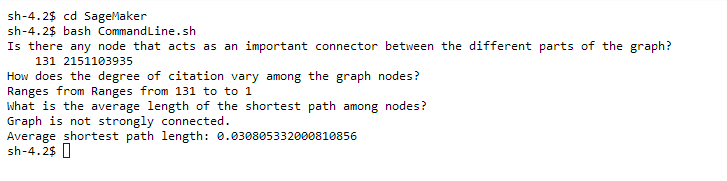

Explaination of what is done in each part

1. **Question 1**:
- It looks for instances of the goal nodes in a list links or mentions (known by 'target' feature).
- Cuts the node IDs from text using Unix tools like `cut`.
- Uses `uniq -c` to count the number of times each node ID appears.
- Sorts the counts in a way that goes down from biggest to smallest using `sort -nr`.
- Displays the first line, with the largest count done by `get head -n 1`.
- This gives the node number, seen as a possible linker among various parts of the illustration.

2. **Question 2**:
- Like Question 1, it measures how often the target nodes show up in a citation graph and lists them.
- Uses `awk` to arrange the results like "Ranges from X" where X is input.
- It locates the highest and lowest counts.
- Provides information about the differing levels of connections that nodes have.

3. **Question 3**:
- Checks if a social network is really linked using NetworkX.
- If very connected, it caves and shows the average quickest path length for the whole picture.
- If not well connected, it figures out the average shortest path length for each part of those components that are strongly linked. These parts should be studied one by one separately.
- Shows the average length of shortest paths in total, looking at all parts connected together.

----------

## 5. Algorithmic Questions (AQ)

### Part A

In [3]:
# Line 1 input: (N, M and S)
N, M, S = input("Enter N, M and S values space separated: ").split(" ")
N, M, S = int(N), int(M), int(S)

# Line 2 input: Set of skills (S)
skillsReq = input("Enter skills space separated: ").split(" ")

# Line 3 input: Player id, Skill and Skill score

skillsAndSkillScore = {}
# skillsAndSkillScore = []

for i in range(N):
    playerId = int(input())
    for ii in range(S):
        playerSkill, skillScore = input().split()
        if playerSkill in skillsAndSkillScore:
            skillsAndSkillScore[playerSkill].append(int(skillScore))
        else:
            skillsAndSkillScore[playerSkill] = [int(skillScore)]

teamScore = 0

# Sort Scores

for key, _ in skillsAndSkillScore.items():
    skillsAndSkillScore[key] = sorted(skillsAndSkillScore[key], reverse=True)

print("Sorted scores are: ", skillsAndSkillScore)

for skill in skillsReq:
    if skill in skillsAndSkillScore:
        if len(skillsAndSkillScore[skill]) <= 0:
            teamScore += 0
        else:
            score = skillsAndSkillScore[skill].pop(0)
            teamScore += score
    else:
        teamScore += 0
    print("Skills and skill score is: ", skillsAndSkillScore)
    print("Team score is: ", teamScore)

print(teamScore)

Enter N, M and S values space separated:  14 10 1
Enter skills space separated:  SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK
 1
 BSK 98
 2
 ATH 14
 3
 HCK 82
 4
 HCK 9
 5
 FTB 90
 6
 ATH 52
 7
 HCK 95
 8
 TEN 85
 9
 RGB 46
 10
 SWM 16
 11
 VOL 32
 12
 SOC 41
 13
 SWM 59
 14
 SWM 34


Sorted scores are:  {'BSK': [98], 'ATH': [52, 14], 'HCK': [95, 82, 9], 'FTB': [90], 'TEN': [85], 'RGB': [46], 'SWM': [59, 34, 16], 'VOL': [32], 'SOC': [41]}
Skills and skill score is:  {'BSK': [98], 'ATH': [52, 14], 'HCK': [95, 82, 9], 'FTB': [90], 'TEN': [85], 'RGB': [46], 'SWM': [34, 16], 'VOL': [32], 'SOC': [41]}
Team score is:  59
Skills and skill score is:  {'BSK': [98], 'ATH': [52, 14], 'HCK': [95, 82, 9], 'FTB': [90], 'TEN': [85], 'RGB': [46], 'SWM': [34, 16], 'VOL': [], 'SOC': [41]}
Team score is:  91
Skills and skill score is:  {'BSK': [98], 'ATH': [14], 'HCK': [95, 82, 9], 'FTB': [90], 'TEN': [85], 'RGB': [46], 'SWM': [34, 16], 'VOL': [], 'SOC': [41]}
Team score is:  143
Skills and skill score is:  {'BSK': [98], 'ATH': [14], 'HCK': [95, 82, 9], 'FTB': [90], 'TEN': [85], 'RGB': [46], 'SWM': [34, 16], 'VOL': [], 'SOC': [41]}
Team score is:  143
Skills and skill score is:  {'BSK': [98], 'ATH': [14], 'HCK': [95, 82, 9], 'FTB': [90], 'TEN': [85], 'RGB': [46], 'SWM': [34, 16], 'VOL

1. **Input Collection:**
- Takes three space-separated inputs: N is the number of players, M represents skills and S shows how many abilities a team requires.
- The team wants a list of abilities, which should be divided by spaces.

2. **Player Skill and Score Storage:**
- Begin a list (`skillsAndSkillScore`) to store player abilities and their related scores.
- It goes through every player and gets their ID with skill-score pairs.
- This info is stored in the dictionary.

3. **Sorting Scores:**
- Sort the scores for each skill from best to worst.

4. **Team Score Calculation:**
- Makes a variable (`teamScore`) equal to zero.
- Repeats the essential skills needed for a group.
- For each skill:
- Checks if the ability is in the player's skills.
- If present:
- Checks if the skill has a score.
- If there is one, it gets the highest mark. It adds that to the team's total and takes it away from a list of scores.
- If they don't have it, the team gets 0 points.
- If you don't have the skill, it won't help your team score points.
- Shows the updated `skillsAndSkillScore` and current team score.

5. **Final Output:**
- Prints the final team score.